In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
#from keras.models import sequential

import glob, os, random, zipfile
import tensorflow as tf

In [ ]:
dataset_path = '/content/gdrive/MyDrive/Dataset'
zip_file = zipfile.ZipFile('/content/gdrive/MyDrive/Dataset/Apple-Disease.zip')
zip_file.extractall(dataset_path)
zip_file.close()

In [ ]:
base_path = os.path.join(dataset_path, '/content/gdrive/MyDrive/Dataset/Apple-Disease/train')

img_list  = glob.glob(os.path.join(base_path, '*/*.JPG'))

print(len(img_list))

7771


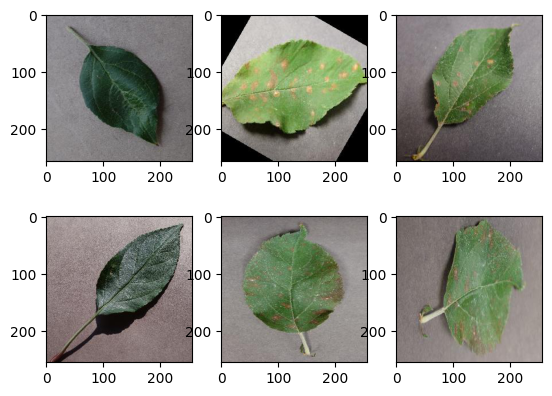

In [ ]:
for i, img_path in enumerate(random.sample(img_list, 6)):
    if not os.path.exists(img_path):
        continue

    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = train_datagen.flow_from_directory(
     base_path,
     target_size=(224, 224),
     batch_size=32,
     class_mode='categorical',
     subset='validation',
     seed=0
)

test_generator = test_datagen.flow_from_directory(
     base_path,
     target_size=(224, 224),
     batch_size=32,
     class_mode='categorical',
     subset='validation',
     seed=0
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)



Found 6218 images belonging to 4 classes.
Found 1553 images belonging to 4 classes.
Found 1553 images belonging to 4 classes.
{0: 'Apple Scab', 1: 'Black Rot', 2: 'Cedar Apple Rust', 3: 'Healthy'}


In [ ]:
mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape=(224 , 224, 3),
                                           include_top=False,
                                           weights='imagenet')

model = Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(4, activation="softmax" , name="classification"))

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005,momentum=0.9), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                         

In [ ]:
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
195/195 [==============================] - 115s 589ms/step - loss: 0.0088 - accuracy: 0.9971 - val_loss: 0.0062 - val_accuracy: 0.9981
Epoch 2/10
195/195 [==============================] - 113s 580ms/step - loss: 0.0070 - accuracy: 0.9986 - val_loss: 0.0056 - val_accuracy: 0.9981
Epoch 3/10
195/195 [==============================] - 113s 577ms/step - loss: 0.0104 - accuracy: 0.9969 - val_loss: 0.0060 - val_accuracy: 0.9981
Epoch 4/10
195/195 [==============================] - 116s 593ms/step - loss: 0.0053 - accuracy: 0.9987 - val_loss: 0.0043 - val_accuracy: 0.9974
Epoch 5/10
195/195 [==============================] - 115s 588ms/step - loss: 0.0065 - accuracy: 0.9986 - val_loss: 0.0038 - val_accuracy: 0.9987
Epoch 6/10
195/195 [==============================] - 114s 585ms/step - loss: 0.0058 - accuracy: 0.9989 - val_loss: 0.0037 - val_accuracy: 0.9994
Epoch 7/10
195/195 [==============================] - 132s 679ms/step - loss: 0.0061 - accuracy: 0.9986 - val_loss: 0.0043 -

49/49 [==============================] - 22s 455ms/step - loss: 0.0042 - accuracy: 0.9994


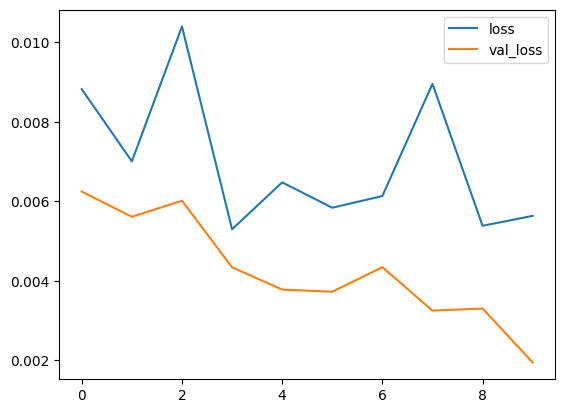

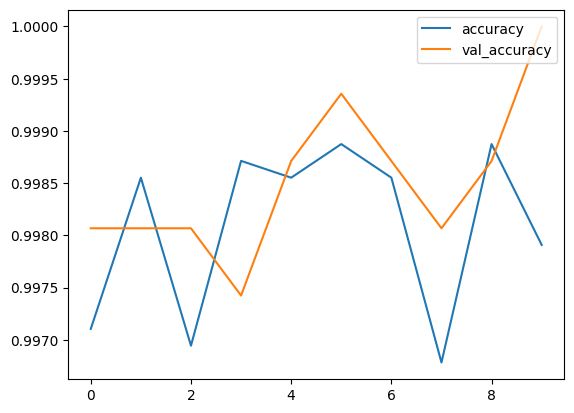

In [ ]:
model.evaluate(validation_generator)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

1/1 [==============================] - 0s 480ms/step


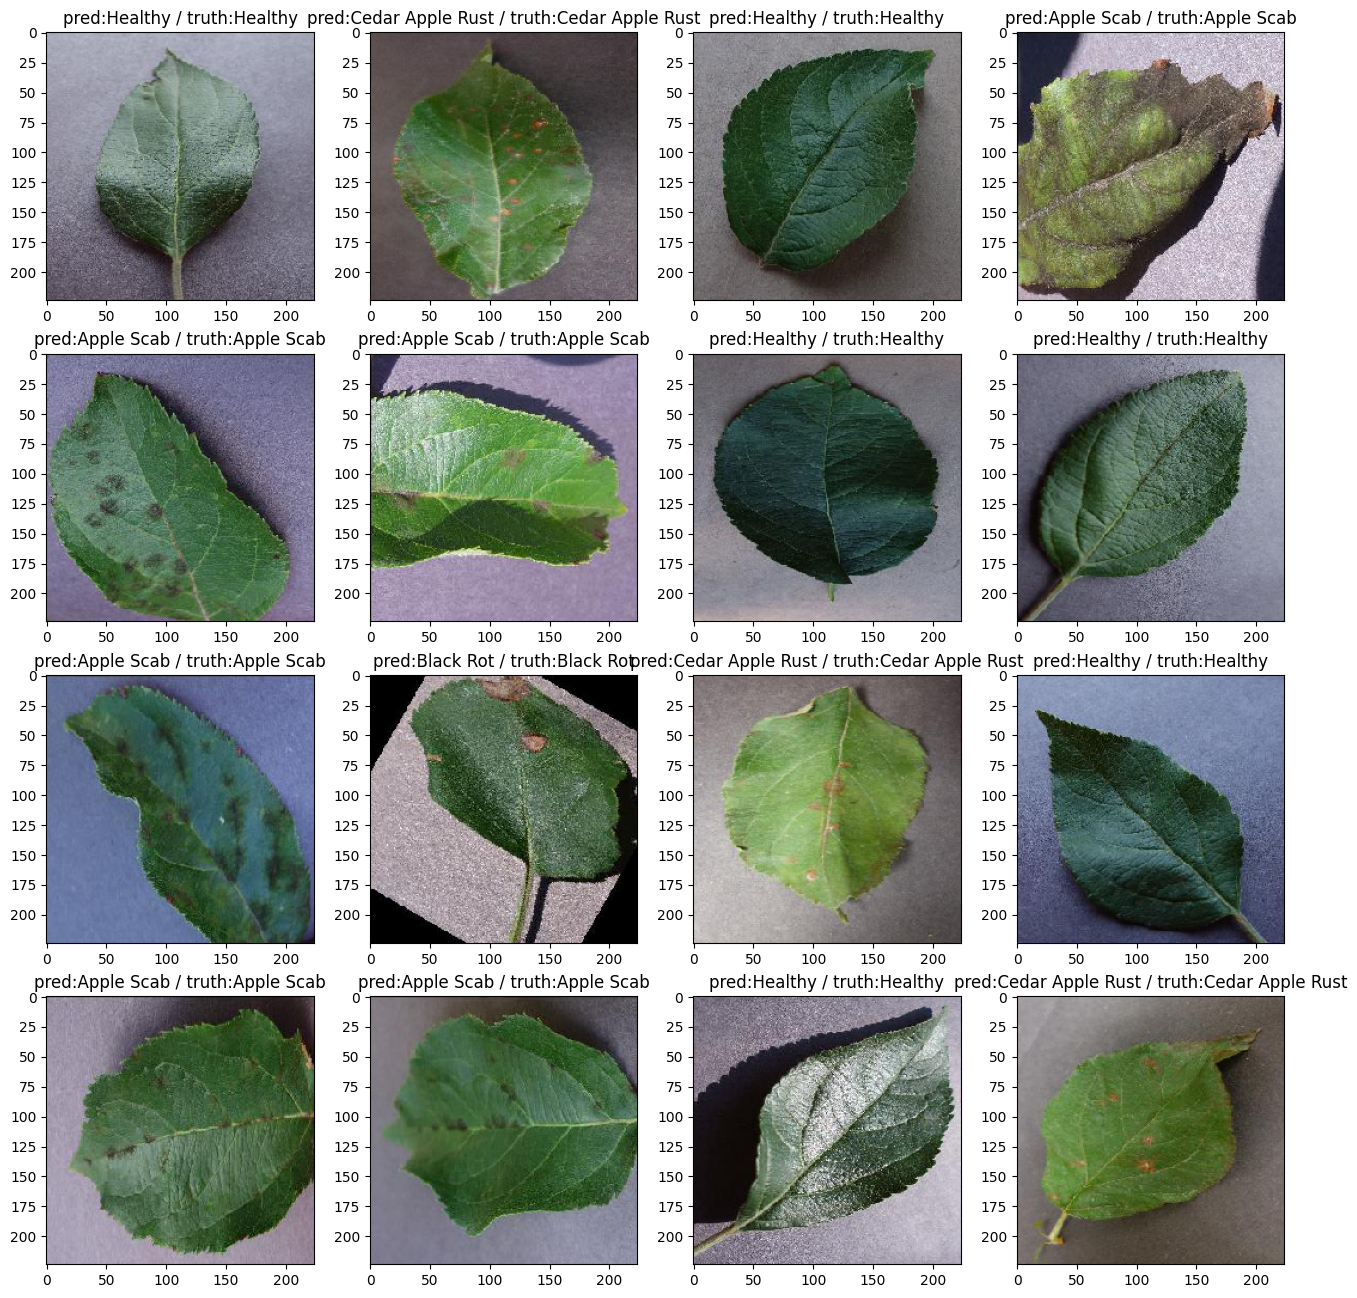

In [ ]:
test_x, test_y = test_generator.__getitem__(1)

preds = model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
  plt.imshow(test_x[i])

In [ ]:
# saving model
model.save_weights("model_leafnet_tf.h5")